In [1]:
import numpy as np
import librosa
import pretty_midi
import matplotlib.pyplot as plt
import IPython.display as ipd
import sounddevice as sd
import librosa.display
import math
import scipy
import time
from scipy import signal

In [2]:

sr = 48000

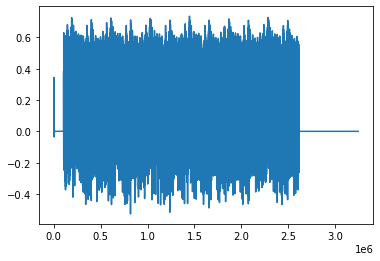

In [20]:
# Importing audio file

s, r = librosa.load('./Files/py5-Bass synth.wav', sr=sr)
#s2, r2 = librosa.load('./Files/py5-Bass synth', sr=sr)

plt.plot(s)

In [8]:
# Functions to apply to the segmented audio

def fade(segment, fadesize):
    fades = np.array([])
    fadesize = fadesize
    if segment.size <= (fadesize*2):
        fadesize = int(segment.size / 10)
        midpart = np.ones(segment.size - (int(fadesize*2)))
        fadein = np.linspace(0,1,num=fadesize)
        fadeout = np.linspace(1,0,num=fadesize)
        fades = np.concatenate((fadein, midpart, fadeout))
        
    else:         
        midpart = np.ones(segment.size - (int(fadesize*2)))   
        fadein = np.linspace(0,1,num=fadesize)
        fadeout = np.linspace(1,0,num=fadesize)
        fades = np.concatenate((fadein, midpart, fadeout))
        
    y = segment * fades
    
    return y


def sizecheck(segment, result):
    if segment.size != result.size:
        if segment.size > result.size:
            diff = segment.size-result.size            
            segment = np.delete(segment_final, diff)
            
        elif result.size > segment.size:
            zeros= np.zeros(result.size - segment.size)
            
            segment = np.concatenate((segment, zeros))
    else:
        pass
    
    return segment

def padder(segment, audiototal, current_beat):
    y = np.pad(segment, [current_beat, audiototal.size-(current_beat+segment.size)])
    return y

def overlapper(segment, overlap):
    x = segment[overlap:segment.size]
    y = np.pad(x, [0, overlap])
    return y

In [9]:
"""FX processing functions"""

def compressor(audio, threshold, makeup, smoothness):
    x = np.array([])
    x = np.append(x, audio)
    for i in range(smoothness):
        index = 0        
        for i in x:        
            if np.abs(i) >= threshold + 0.3:
                x[index] = i * 0.85                 
            elif np.abs(i) >= threshold + 0.2:
                x[index] = i * 0.90            
            elif np.abs(i) >= threshold + 0.1:
                x[index] = i * 0.95            
            elif np.abs(i) >= threshold:
                x[index] = i * 0.99            
            else:
                x[index] = i
            index += 1
            
    y = x * (1+makeup)
    
    return y

def IRDelay(audio, impulses, sr=sr):
    s = np.pad(audio, [0, audio.size])
    s = fade(s, 1024)
    
    impulse_array = np.linspace(0.2, 0, num=impulses)
    IRarray = np.array([])
    size = int(s.size/impulses)-1
    for i in range(impulses):

        IRarray = np.append(IRarray, np.zeros(size))
        IRarray = np.append(IRarray, impulse_array[i])

    IRarray = sizecheck(IRarray, s)

# transform to frequency domain
    Y = scipy.fft.fft(s)
    H = scipy.fft.fft(IRarray)

# applying convolution
    output = Y*H

# back to time domain
    output = np.real(scipy.fft.ifft(output))
    return output


def allpass(delay, gain):
    b = np.zeros(delay)
    b[0] = gain
    b[delay-1] = 1
    a = np.zeros(delay)
    a[0] = 1
    a[delay-1] = gain
    return b,a


def IIRReverb(audio, combq, delay1, gain1, delay2, gain2):
    
    """A Schroeder reverb with four parallell comb filters and two cascading allpass filters.
    audio = the audio that you will apply the reverb on
    combq = Q factor of the comb filters. Play around but 20 is a good place to start
    delay1 = the delay of the first allpass filter, try settings around 1000
    gain1 = the gain of the first allpass, try anything between 0 and 1, closer to 1 
    results in more volume in the reverb
    delay2 = same as delay1 but for the second allpass filter. Try a different and slightly longer
    value than delay1, for example 3500
    gain2 = same as gain1 but for the second allpass filter"""
    
    s_tail = audio
    s_tail = np.append(s_tail, np.zeros(48000))    
    
    # First comb filter
    f0 = 200  
    Q = combq  
    b1,a1 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y1 = signal.lfilter(b1,a1,s_tail)
    # Second comb filter 
    f0 = 300  
    Q = combq  
    b2,a2 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y2 = signal.lfilter(b2,a2,s_tail)
    # Third comb filter
    f0 = 400  
    Q = combq  
    b3,a3 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y3 = signal.lfilter(b3,a3,s_tail)
    # Fourth comb filter
    f0 = 500 
    Q = combq  
    b4,a4 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y4 = signal.lfilter(b4,a4,s_tail)
    # computing up the parallell structure by adding them together (and scaling the amplitude)
    comb_result = (y1 + y2 + y3 + y4)*0.2
    # Designing the two allpass filters
    b1,a1 = allpass(delay1, gain1)
    b2,a2 = allpass(delay2, gain2)

    # Convolving the coefficients to get the cascading structure
    cascade_a = np.convolve(a1,a2)
    cascade_b = np.convolve(b1,b2)

    # Run the result from the comb parallell filters through the cascade of allpass filters
    signal_output = signal.lfilter(cascade_b, cascade_a, comb_result)
    # Merging wet with dry
    #audio = np.append(audio, np.zeros([signal_output.size-audio.size]))
    #output = ((signal_output * wet)+audio)*0.5
    
    
    return signal_output


def framecompressor(audio, frame_length, threshold, ratio, makeup):
    
    """audio = audio to be compressed
    frame_length = compression window, try 2048
    threshold = what value of amplitude will cause the compressor to compress, try 0.3
    ratio = a float from 0 to 1, 0 will result in total gainremoval in the middle
    of the compressor window and 1 will result in no compression. 
    makeup = how much you multiply the audio with after compression. Try 1.1 or 1.2
    
    """
    window = signal.get_window('hann', frame_length)    
    b = np.array([-ratio])
    c = signal.convolve(window, b)
    window = c + 1
    
    x = np.array([])
    x = np.append(x, audio)
    
    for i in range(0, len(audio), int(frame_length*0.5)):
                
        s = x[i:i + frame_length]        
        a = np.max(np.abs(s))
        if a > threshold:            
            s = s * window
            x[i:i+frame_length] = s
        
    compressed = x * makeup
    return compressed

def reverse(audio):
    s = np.flip(audio)
    return s


def softClipper(audio, drive, output=0.8):

    """audio = Source to be SoftClipped
    drive = Amount of SoftClipping (Try between 10-40)
    output = Output volume
    
    The signal is normalized before output attenuation for better control.
    """
    
    # Drive can not be set to 0
    if drive == 0:
        drive = 1
    
    piDivisor = 2 / np.pi
    driver = np.arctan(audio * drive)
    
    softclip = piDivisor * driver
    
    normalized = softclip/np.max(softclip)
    softClipped = normalized * output
    
    return softClipped

def FIR_fft(signal, order, passband_hz, stopband_hz, pass_zero='lowpass', sr=44100):
    
    numtaps = order-1 # filter length (or number of tabs)
    
    wp = passband_hz/(sr/2) # passband edge normalized frequency
    ws = stopband_hz/(sr/2) # stopband edge normalized frequency

    freqs = [0.0, wp, ws, 1.0]
    
    if pass_zero == 'lowpass':
        gains = [1.0, 1.0, 0.0, 0.0] # normalized gain values (0.5 = -3 dB)
    elif pass_zero == 'highpass':
        gains = [0.0, 0.0, 1.0, 1.0] # normalized gain values (0.5 = -3 dB)
                
    # Compute the FIR filter coefficients 
    h = sig.firwin2(numtaps, freqs, gains, window='hann') # compute FIR coefficients using firwin2 function
    
    # Design the FIR filter in the frequency domain 
    h_padded = np.pad(h,[0,len(signal)-len(h)]) # pad FIR coefficients with zeros in order to match the signal length
    
    # Apply the discrete Fourier Transform to the FIR filter (move to the frequency domain)
    X = scipy.fft.fft(signal)
    H = scipy.fft.fft(h_padded)
    
    Y = X*H # do the product of the DFT of the signal with the padded filter impulse response
    
    # Apply the inverse discrete Fourier Transform to the FIR filter (back to the time domain)
    y = np.real(scipy.fft.ifft(Y))
        
    return y #signal filtered in the frequency domain

In [ ]:
#b = IIRReverb(s, 0.9, 20, 800, 0.78, 1700, 0.68)
#xx = IRDelay(s, 4)
#first = framecompressor(s, 2048,0.45, 0.6, 1.7)
#sd.play(first)
#plt.plot(first)

#sd.play(b)
#sd.wait()
#sd.play(xx)

In [10]:
# If we want to resynthesize anything these can come in handy


def sawtooth_synth(freq, dur_ms, sr=sr, amp=1, phase=1):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp * signal.sawtooth(2 *np.pi*freq*t*phase)

    return s

def triangle_synth(freq, dur_ms, sr=sr, amp=1, phase=1, width=0.5):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp * signal.sawtooth(2 *np.pi*freq*t*phase)

    return s

def sine_synth(freq, dur_ms, sr=sr, amp=1, phase=1):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp*np.sin(2*np.pi*freq*t*phase)
    
    return s
    

def square_synth(freq, dur_ms, sr=sr, amp=1, phase=1):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp*signal.square(2*np.pi*freq*t*phase)
    
    return s


# Repurposing the sine_synth as a LFO (for PWM).
def myLFO(lfo_hz, dur_ms, lfo_depth):
    if lfo_depth < 0.01:
        lfo_depth = 0.01
    elif lfo_depth > 0.99:
        lfo_depth = 0.99
    lfo = sine_synth(lfo_hz, dur_ms, amp=lfo_depth)
    
    return lfo


def myPWM(freq, lfo_hz, dur_ms, lfo_depth=0.9):
    t = np.linspace(0, 1, sr*(int(dur_ms/1000)), endpoint=False)
    lfo = myLFO(lfo_hz, dur_ms, lfo_depth)
    pwm = signal.square(2 * np.pi * freq * t, duty=(lfo + 1)/4)
    
    return pwm


def chirp_sound(freq_start, freq_end, dur_ms, amp=1):
    
    t = np.arange(0, int((dur_ms/1000)*sr)) / sr
    s = amp * signal.chirp(t, f0=freq_start, f1=freq_end, t1=dur_ms/1000, method='linear')

    return s

# Multiply the amp_envelope with your generated signal note by note 
# to get a nice smooth attack and decay

def amp_envelope(dur_ms, sr=sr):
    
    t = np.arange(0, dur_ms/1000, 1/sr)
    
    # Splitting t up into 4 parts
    attack_length = int(len(t) / 20)
    decay_length = int(len(t) / 4)
    sustain_length = int(len(t) / 2)
    release_length = int(len(t) - (attack_length + decay_length + sustain_length))
    
    # Setting the start and stop amplitube values for the ramps
    attack = np.linspace(0, 0.9, num=attack_length)
    decay = np.linspace(0.9, 0.75, num=decay_length)
    sustain = np.linspace(0.75, 0.6, num=sustain_length)
    release = np.linspace(0.6, 0, num=release_length)
    
    # Putting them together in order
    env = np.concatenate((attack, decay, sustain, release))
    
    return env

### PWM & SoftClip-test below (for deletion)

In [11]:
PWMtest = myPWM(330, 1, 2000, 0.95)

sd.play(PWMtest)
sd.wait()

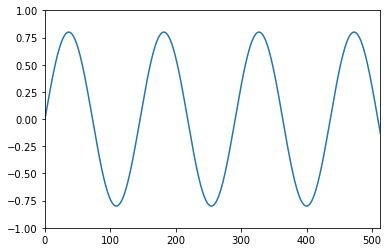

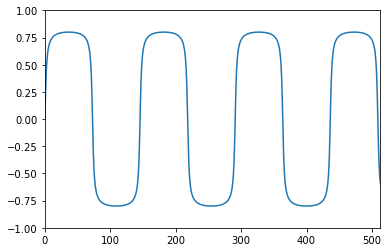

In [12]:
twosecsine = sine_synth(330, 2000, amp=0.8)

sinedrive = softClipper(twosecsine, 15)

# original
plt.plot(twosecsine)
plt.axis(ymin=-1, ymax=1, xmin=0, xmax=512)
plt.show()
sd.play(twosecsine)
sd.wait()

# softclipped
plt.plot(sinedrive)
plt.axis(ymin=-1, ymax=1, xmin=0, xmax=512)
plt.show()
sd.play(sinedrive)
sd.wait()

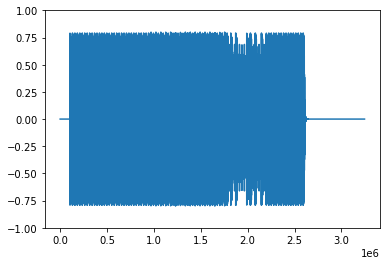

In [13]:
musicdrive = softClipper(s, 30)

plt.plot(musicdrive)
plt.axis(ymin=-1, ymax=1)
plt.show()
sd.play(musicdrive)

---

In [14]:
#loading midi and displaying info

pm = pretty_midi.PrettyMIDI('./Files/py5.midi')


In [15]:
# Actual bpm is 110, this returns 221.5
print(pm.estimate_tempo())

downbeats_in_seconds = pm.get_downbeats()
print(downbeats_in_seconds.size)
downbeats_sample_time = downbeats_in_seconds*48000
downbeats_sample_time = downbeats_sample_time. astype(int)
downbeats_sample_time = downbeats_sample_time[1:]
print(downbeats_sample_time)


221.53419267088816
29
[ 104727  209454  314181  418908  523635  628363  733090  837817  942544
 1047271 1151998 1256726 1361453 1466180 1570907 1675634 1780361 1885089
 1989816 2094543 2199270 2303997 2408724 2513452 2618179 2722906 2827633
 2932360]


In [16]:
s.size


3246546

104727
0


<ipython-input-9-a176091a82b7>:48: RuntimeWarning: invalid value encountered in true_divide
  return output/np.max(output)


209454
1
314181
2
418908
3
523635
0
628363
1
733090
2
837817
3
942544
0
1047271
1
1151998
2
1256726
3
1361453
0
1466180
1
1570907
2
1675634
3
1780361
0
1885089
1
1989816
2
2094543
3
2199270
0
2303997
1
2408724
2
2513452
3
2618179
0
2722906
1
2827633
2
2932360
3


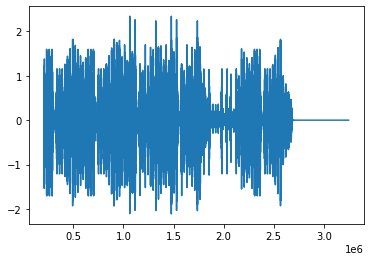

In [19]:
# Have patience, it takes some time

# Creating the result array we will add all signals back into
result = np.zeros(s.size) 

# Temporary arrays used in the for loop
segment = np.array([])
seg = np.array([])

# Setting parameters for the loop
counter = 0
current_beat = 0
overlap = 0
overlap_length = 1024


# This is the main slicing and processing part of the program

for i in downbeats_sample_time:
    # To check computational time and where it struggles
    print(i)
    print(counter)
    
    counter += 1
    
    # Slicing the segment from current_beat to the sample position i
    seg = s[current_beat:i]    
    # adding fade ins and outs to the segment
    segment = fade(seg, overlap_length)
    
    if counter == 1:
        
        segment = compressor(segment, 0.3, 1, 1)
        seg_fx = IRDelay(segment, 8)
        segment_padded = padder(segment, s, current_beat)
        segment_fx = padder(seg_fx, s, current_beat)
          
        segment_padded = (segment_padded + segment_fx)
                
    elif counter == 2:
        segment = compressor(segment, 0.3, 1, 1)
        segment_padded = padder(segment, s, current_beat)
        
    elif counter == 3:
        segment = compressor(segment, 0.3, 1, 1)
        seg_fx = IIRReverb(segment, 20, 800, 0.78, 1700, 0.68)
        segment_padded = padder(segment, s, current_beat) 
        segment_fx = padder(seg_fx, s, current_beat)
          
        segment_padded = (segment_padded + segment_fx)

    elif counter == 4: 

        segment = compressor(segment, 0.3, 1, 1)
        segment = reverse(segment)
        segment_padded = padder(segment, s, current_beat)
    
    # updating the current beat for the next loop
    current_beat = current_beat + seg.size    
    segment_overlapped = segment_padded[overlap:segment_padded.size]
    
    # getting the size right again by adding zeros to the end:
    segment_final = np.pad(segment_overlapped, [0, overlap])

    # Increasing overlap for next round of for loop 
    overlap = overlap + overlap_length
    
    # Just making sure the sizes are allright 
    segment_final = sizecheck(segment_final, result)
    
    # Resetting the counter when it reaches 4
    if counter == 4:
        counter = 0
    # pasting the segments back in, one by one
    result = result + segment_final

# Normalizing volume    
#result = result/np.max(result)
# Playing back the result
    
#final = framecompressor(result, 2048,0.40, 0.5, 1.7)   
sd.play(result)
plt.plot(result)



In [ ]:
print(result.size)
print(result.shape)
print(s.size)
print(s.shape)

In [ ]:
print(type(seg))

## Visualizations

#### Audacity (Peak + RMS)

In [ ]:
# Import features.py to access our RMS-function
import features

In [ ]:
## A function to display in the style of Audacity

def vizAudacity(audio):

    frame_length = 512
    
    # Finding the RMS
    rms_values = features.root_mean_square(audio, 2048, frame_length)
    
    # Making a waveform with the RMS values
    rms_audio = []
    count = 0
    
    for i in range(0, len(s), frame_length): #in your case 512
        chunk = s[i:i + frame_length]
        try:
            a = rms_values[count]*chunk
        except:
            break
        rms_audio = np.append(rms_audio, a)
        count += 1
    
    # Choosing style and colors for the plot
    plt.style.use('seaborn-white')
    fig, ax = plt.subplots(figsize=(16, 4), facecolor='#e7e7e7', dpi=150.0)
    ax.set_facecolor('#c0c0c0')

    # Setting labels
    ax.set_title("Audacity style waveform", fontsize='24', weight='roman', y=1.02, family='monospace')
    ax.set_xmargin(0.005)

    # Plotting the outer waveform (Peak/Amplitude)
    ax.plot(audio, color='#3132c1')

    # Plotting the inner waveform (RMS)
    ax.plot(rms_audio, color='#6464d5')

    # Generating lists for showing x-axis ticks every 15 sec,
    # by finding the floor value of (length // 15) + 1 for the np.arange().
    tick_stop = ((len(s)/sr)//15)+1
    s_ticks_value = np.arange(sr*15,sr*15*tick_stop,sr*15)
    s_ticks = np.arange(int(15),int(15*tick_stop),15)

    # Showing minutes instead of samples
    ax.set_xticks(s_ticks_value)
    ax.set_xticklabels(s_ticks)
    ax.axis(ymin=-1, ymax=1)

    # Displaying the plot
    fig.tight_layout()
    plt.show()

In [ ]:
vizAudacity(s)

#### Traktor/Serato (Colored by Spectral Centroid)
```Colored Waveforms

Colors in the waveform show the frequency of the sound:
bass is red, mids are green, treble is blue.
                                        (www.serato.com)
```


In [ ]:
## A function to display in the style of Serato/Traktor

def vizSerato(audio):

    # Finding the Spectral Centroid
    #audio_centroid = features.spectral_centroid(audio, 2048, 512)
    audio_centroid = librosa.feature.spectral_centroid(audio, sr=sr, n_fft=2048, hop_length=512)
    
    # Choosing style and colors for the plot
    plt.style.use('seaborn-white')
    fig, ax = plt.subplots(figsize=(16, 4), facecolor='#373737', dpi=150.0)
    ax.set_facecolor('#000000')

    # Setting labels
    ax.set_title("Serato/Traktor style waveform", fontsize='24', weight='roman', y=1.02, family='monospace', color='#f4f4f4')
    ax.set_xmargin(0.005)

    # Plotting the outer waveform (Peak/Amplitude)
    ax.plot(audio, color='#c94c87')

    # Generating lists for showing x-axis ticks every 15 sec,
    # by finding the floor value of (length // 15) + 1 for the np.arange().
    tick_stop = ((len(s)/sr)//15)+1
    s_ticks_value = np.arange(0,sr*15*tick_stop,sr*15)
    s_ticks = np.arange(int(0),int(15*tick_stop),15)

    # Showing minutes instead of samples
    ax.set_xticks(s_ticks_value)
    ax.set_xticklabels(s_ticks, color='#f4f4f4')
    ax.tick_params(axis='y', colors='#f4f4f4')
    ax.axis(ymin=-1, ymax=1)

    # Displaying the plot
    fig.tight_layout()
    plt.show()

In [ ]:
vizSerato(s)

## Might be something for the Serato colorplotting below:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
dydx = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig.colorbar(line, ax=axs[0])

# Use a boundary norm instead
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[1].add_collection(lc)
fig.colorbar(line, ax=axs[1])

axs[0].set_xlim(x.min(), x.max())
axs[0].set_ylim(-1.1, 1.1)
plt.show()